<a href="https://colab.research.google.com/github/ajaynain-eng/Self-Driving-Car/blob/main/Lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import os
import time
import glob
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip
import warnings
warnings.filterwarnings("ignore")

In [9]:
# from IPython.core.display import clear_output
# cap = cv2.VideoCapture("/content/drive/MyDrive/My Projects/Lane Detection/video_1.mp4")

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         print("NO")
#         break
#     else:
#         print("yes")
#         clear_output(wait = True)
#         cv2_imshow(frame)
#         time.sleep(1.1)

#     if cv2.waitKey(11000) == ord("q"):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [12]:
try:
    os.chdir("/content/drive/MyDrive/My Projects/Lane Detection")
except:
    pass

In [13]:
def calibrate_camera():
    # Prepare grid of object points with same shape matching 
    # number of corners in chess board and then flatten to give an array
    # The array contains grid location of a perfect image of chess board
    grid_points = np.zeros((6*9, 3), np.float32)
    grid_points[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Store the object points and corresponding corner points of chess board
    grids_points = []
    corner_points = []
    chess_images = glob.glob("camera_cal/*.jpg")

    for idx, fname in enumerate(chess_images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret:
            grids_points.append(grid_points)
            corner_points.append(corners)
    
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(grids_points, corner_points, img_size, None, None)

    # save camera calibration
    calibration = {}
    calibration["mtx"] = mtx
    calibration["dist"] = dist
    with open("camera_cal/camera_calibration.pkl", "wb") as file:
        pickle.dump(calibration, file)

def undistort_image(img, calibration_path = "camera_cal/camera_calibration.pkl"):
    with open(calibration_path, "rb") as f:
        file = pickle.load(f)
    mtx = file["mtx"]
    dist = file["dist"]
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

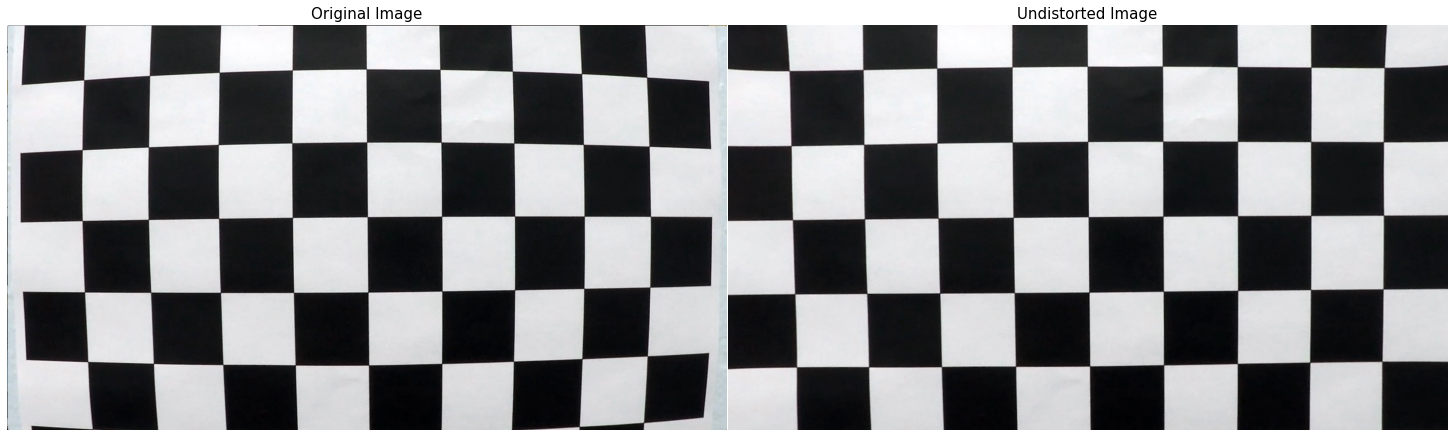

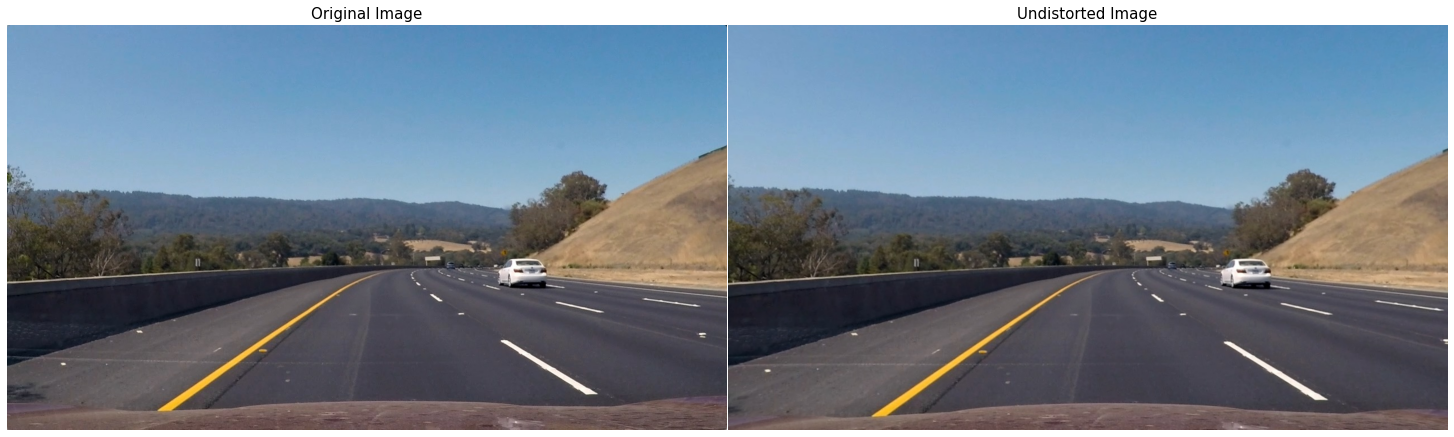

In [14]:
calibrate_camera()

img = cv2.imread('camera_cal/calibration1.jpg')
dst = undistort_image(img)

# Visualize undistortion of chess board image
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax1.axis("off")
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=15)
ax2.axis("off")
plt.tight_layout(pad = 0, h_pad = 0.1, w_pad = 0.1)


# Visualize undistortion of available road image.
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = undistort_image(img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax1.axis("off")
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=15)
ax2.axis("off")
plt.tight_layout(pad = 0.0, h_pad = 0.1, w_pad = 0.1)

In [15]:
def masking_road_lines(img, s_thresh=(100, 255), sx_thresh=(15, 255)):
    img = undistort_image(img)
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]

    # Detecting edges (gradient of edge intensity) for lightness using Sobel filter
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))*255
    
    # combining the mask for gradient and Saturation
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def perspective_warp(img, 
                     dst_size=(1280,720),
                     src=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)]),
                     dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    # For destination points, i am arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = dst * np.float32(dst_size)
    # Using src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

def inv_perspective_warp(img, 
                     dst_size=(1280,720),
                     src=np.float32([(0,0), (1, 0), (0,1), (1,1)]),
                     dst=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

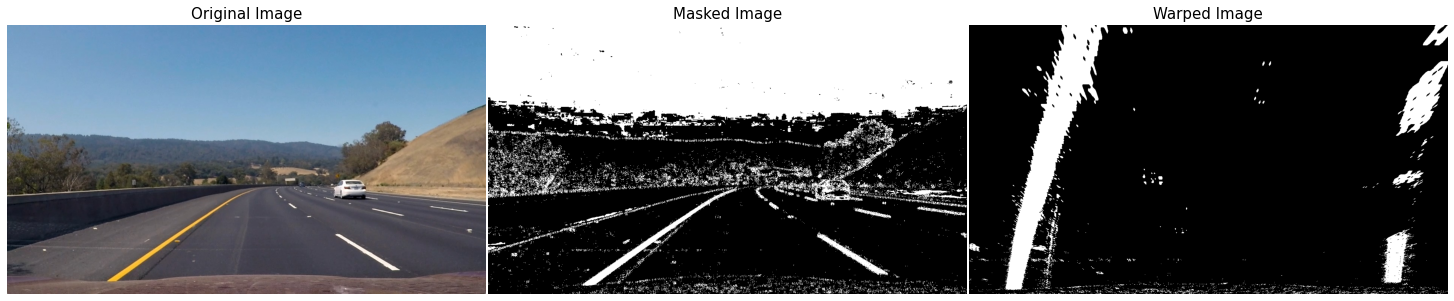

In [21]:
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bulered_img = cv2.blur(img, (5,5))
masked_img = masking_road_lines(img)
wraped_img = perspective_warp(masked_img, dst_size=(1280,720))
# Visualize undistortion
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax1.axis("off")

ax2.imshow(masked_img, cmap='gray')
ax2.set_title('Masked Image', fontsize=15)
ax2.axis("off")

ax3.imshow(wraped_img, cmap='gray')
ax3.set_title('Warped Image', fontsize=15)
ax3.axis("off")

plt.tight_layout(pad = 0.0, h_pad = 0.0, w_pad = 0.2)

In [22]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows=9, margin=150, minpix = 1, draw_windows=True):
    global left_a, left_b, left_c,right_a, right_b, right_c 
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img))*255

    histogram = get_hist(img)
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_idxs = []
    right_lane_idxs = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (100,255,255), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (100,255,255), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_idxs = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_idxs = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_idxs.append(good_left_idxs)
        right_lane_idxs.append(good_right_idxs)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_idxs) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_idxs]))
        if len(good_right_idxs) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_idxs]))

    # Concatenate the arrays of indices
    left_lane_idxs = np.concatenate(left_lane_idxs)
    right_lane_idxs = np.concatenate(right_lane_idxs)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_idxs]
    lefty = nonzeroy[left_lane_idxs] 
    rightx = nonzerox[right_lane_idxs]
    righty = nonzeroy[right_lane_idxs] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_idxs], nonzerox[left_lane_idxs]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_idxs], nonzerox[right_lane_idxs]] = [0, 100, 255]
    # return the image with lane, curved lanes, coeff of polynomial equation, vertical axis of image 
    # which will be used to build polynomial equation to give location of lines on road.
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

### If Polynomial equation is:
$x = ay^2 + by^2 + c$

### Then radius of curvature of road is:
$R =$ $\frac{(1+(2ay+b)^2)^{1.5}}{2a}$

In [23]:
def get_curve(img, leftx, rightx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_pos = img.shape[1]/2    # as camera is mounted at the centre of car and giving the image center as car center
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2

    # The center of car should be between two lanes. The offset of car from center is
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

def draw_lanes(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])               # gives 2 columns with x, y 
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])  # gives 2 columns of x, y with flip along horizontal (top comes to down)
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), (0,200,255))
    inv_perspective = inv_perspective_warp(color_img)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective

(2, 720)
(1066.4716417836778, 956.6218685132969, 0.21037513529343105)


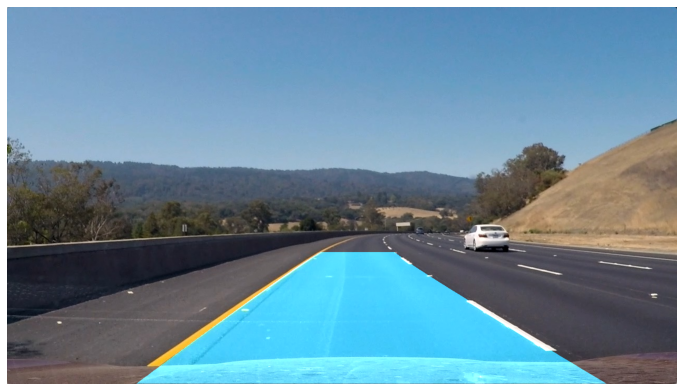

In [26]:
out_img, curves, lanes, ploty = sliding_window(wraped_img)

print(np.asarray(curves).shape)
curverad=get_curve(img, curves[0],curves[1])
print(curverad)
laned_img = draw_lanes(img, curves[0], curves[1])
plt.figure(figsize = (12,7))
plt.imshow(laned_img, cmap='hsv')
plt.axis("off")
plt.show()

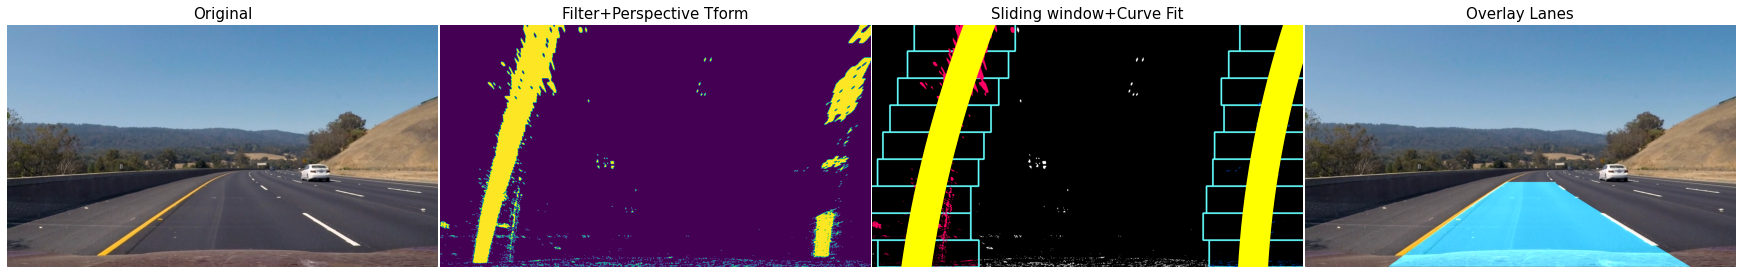

In [33]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 5))
#f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=15)
ax1.axis("off")

ax2.imshow(wraped_img)
ax2.set_title('Filter+Perspective Tform', fontsize=15)
ax2.axis("off")

ax3.imshow(out_img)
ax3.plot(curves[0], ploty, color='yellow', linewidth=30)
ax3.plot(curves[1], ploty, color='yellow', linewidth=30)
ax3.set_title('Sliding window+Curve Fit', fontsize=15)
ax3.axis("off")

ax4.imshow(laned_img)
ax4.set_title('Overlay Lanes', fontsize=15)
ax4.axis("off")

plt.tight_layout(pad = 0.0, h_pad = 0.0, w_pad = 0.2)

In [34]:
def vid_pipeline(img):
    global running_avg
    global index
    img_ = masking_road_lines(img)
    img_ = perspective_warp(img_)
    out_img, curves, lanes, ploty = sliding_window(img_, draw_windows=False)
    curverad =get_curve(img, curves[0], curves[1])
    lane_curve = np.mean([curverad[0], curverad[1]])
    img = draw_lanes(img, curves[0], curves[1])
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize=0.5
    cv2.putText(img, 'Lane Curvature: {:.0f} m'.format(lane_curve), (570, 620), font, fontSize, fontColor, 2)
    cv2.putText(img, 'Vehicle offset: {:.4f} m'.format(curverad[2]), (570, 650), font, fontSize, fontColor, 2)
    return img

In [36]:
def process_the_video(raw_video_path, processed_video_path):
    myclip = VideoFileClip(raw_video_path)
    clip = myclip.fl_image(vid_pipeline)
    clip.write_videofile(processed_video_path, audio=False) 

In [40]:
process_the_video("Test_videos/video_2.mp4", "Processed videos/output_2.mp4")

[MoviePy] >>>> Building video Processed videos/output_2.mp4
[MoviePy] Writing video Processed videos/output_2.mp4


100%|█████████▉| 1199/1200 [04:15<00:00,  4.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Processed videos/output_2.mp4 

